In [25]:
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [26]:
# --- Beam geometry ---
L = 20.0   # length in x
H = 2.0
# --- Material properties ---
E = 200_000
nu = 0.3
# mu = E / (2.0 * (1.0 + nu))
# kappa = E / (3.0 * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))
#kappa = E / (2.0 * (1.0 - nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))

material_props = np.array([mu, kappa])
print(f"Material properties: mu={mu:.3f}, kappa={kappa:.3f}")
q = -1 # load per unit length in x
ndof = 2                  # 2 DOFs per node (x, y)
mu = material_props[0]
# We'll guess E = 3 mu (plane stress, near incompressible) or 2 mu(1 + nu) for plane strain, etc.
# --- Analytical Solution ---
# For a cantilever beam under uniformly distributed load q:
# Euler–Bernoulli tip deflection: w(L) = q * L^4 / (8 * E * I)
# E_eff = E * (1 - nu) / ((1 + nu) * (1 - 2*nu))
E_eff = E / (1 - nu ** 2.0)
I = H ** 3 / 12.0
w_analytical = 5 * q * L ** 4 / (384.0 * E_eff * I)
# w_analytical = q * L ** 4 / (8.0 * E_eff * I)


Material properties: mu=76923.077, kappa=166666.667


In [27]:
meshes = {}
results = {}
for elem_type in ["D2_nn4_quad", "D2_nn8_quad", "D2_nn3_tri", "D2_nn6_tri"]:
    results_ = {}
    for h_size in [1, 0.75, 0.5, 0.1]:
        nx = int(L/h_size)    # number of elements along length
        ny = int(H/h_size) 
        print(f"Generating mesh with {nx}x{ny} elements")
        ele_type = elem_type  # 2D, 4-node quadrilateral (linear)
        ndof = 2                  # 2 DOFs per node (x, y)
        # Generate a rectangular mesh
        coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)
        meshes[f"{elem_type}_{h_size}"] = (coords, connect)

        print(f"Solving for mesh: {elem_type}_{h_size}")
        mesh_name = f"{elem_type}_{h_size}"
        boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
            coords, connect, ele_type, x_lower=0.0, x_upper=L, y_lower=0.0, y_upper=H
        )

        # 1) Clamp the left edge: fix x- and y-displacements = 0
        fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", None, 0.0)
        fixed_right = pre.assign_fixed_nodes_rect(boundary_nodes, "right", None, 0.0)
        # 2) Uniform downward traction on the top edge (y=H)
        # Let q be negative in the y-direction
        
        # For a 2D plane strain problem, this is a traction (tx, ty) = (0, q)
        dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)
        # dload_info[-2, :-1] = 0.0
        # Combine boundary conditions
        fixed_nodes = fixed_left
        fixed_nodes = np.hstack((fixed_left, fixed_right))  # only the left edge is clamped
        nr_num_steps = 1

        # --- Solve with your hyperelastic solver ---
        displacements_all, nr_info_all = hyperelastic_solver(
            material_props,
            ele_type,
            coords.T,      # shape (2, n_nodes)
            connect.T,     # shape (n_nodes_per_elem, n_elems)
            fixed_nodes,
            dload_info,
            nr_print=True,
            nr_num_steps=nr_num_steps,
            nr_tol=1e-10,
            nr_maxit=30,
        )
        results_[h_size] = {"displacement":displacements_all, "mesh": (coords, connect)}
    results[ele_type] = results_

Generating mesh with 20x2 elements
Solving for mesh: D2_nn4_quad_1
Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=3.459444e-02, tolerance=1.000000e-10
Iteration 2, Correction=7.672357e-03, Residual=2.417345e-02, tolerance=1.000000e-10
Iteration 3, Correction=3.030984e-02, Residual=4.590454e-08, tolerance=1.000000e-10
Iteration 4, Correction=1.528877e-02, Residual=1.845892e-12, tolerance=1.000000e-10
Iteration 5, Correction=8.920077e-04, Residual=1.435598e-12, tolerance=1.000000e-10
Iteration 6, Correction=1.679157e-02, Residual=1.455974e-12, tolerance=1.000000e-10
Iteration 7, Correction=1.105093e-03, Residual=1.504991e-12, tolerance=1.000000e-10
Iteration 8, Correction=4.996986e-02, Residual=1.456308e-12, tolerance=1.000000e-10
Iteration 9, Correction=9.184202e-03, Residual=1.702602e-12, tolerance=1.000000e-10
Iteration 10, Correction=7.474774e-04, Residual=1.336788e-12, tolerance=1.000000e-10
Iteration 11, Correction=1.233553e-02, Residual=1.358285e-12, to

20.0

D2_nn4_quad
0.10650647692053102
0.07684955561437046
0.011867278095990029
0.023064267471937017
D2_nn8_quad
0.02432703774197212
0.024349070214343196
0.024262786349081623
0.024555683182387194
D2_nn3_tri
0.4608727071305541
0.4298609771297462
0.16635514411339247
0.015221686994485414
D2_nn6_tri
0.09846071710479529
0.09876941430188269
0.042327247043809094
0.025259872474465508


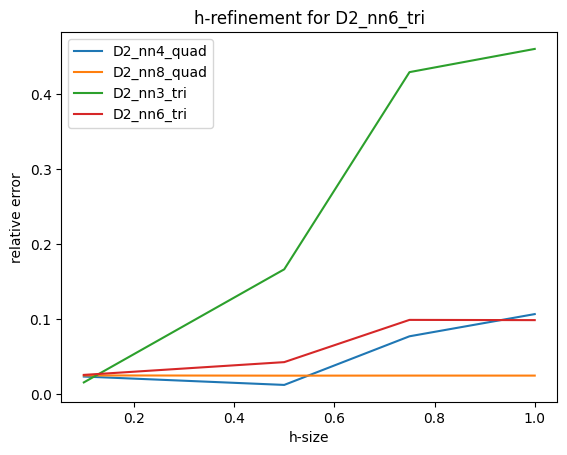

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
# h-refinement
errors = {}
for elem_type in results.keys():
    errors_h = []
    h_sizes = []
    print(elem_type)
    for h_size in results[elem_type].keys():
        final_disp = results[elem_type][h_size]["displacement"][-1]  # shape: (n_nodes*ndof,)
        coords = results[elem_type][h_size]["mesh"][0]
        # print(coords)
        connect = results[elem_type][h_size]["mesh"][1]
        ny = int(H/h_size)
        # --- Compute the tip displacement from the FEA result ---
        # We'll pick a node near x=L/2, y=H/2
        try:    
            mid_node = None
            tol = 1e-3
            for i, (x, y) in enumerate(coords):
                if abs(x - L/2) < tol and abs(y - H/2) < H/(2*ny):
                    mid_node = i
                    break
            if mid_node is None:
                raise ValueError("Could not find tip node near x=L, y=H/2.")

            mid_disp_y = final_disp[ndof*mid_node + 1]  # the y-component of displacement
            # --- Evaluate error ---
            error = abs((mid_disp_y - w_analytical)/w_analytical)
            errors_h.append(error)
            print(error)
            h_sizes.append(h_size)
        except Exception as e:
            print(f"element type: {elem_type}, h_size: {h_size}, Error: {e}")
            continue
    errors[elem_type] = errors_h
    # add a title to the left plot
    plt.plot(h_sizes, errors_h, label=elem_type)
    # plot a log log plot
    # plt.loglog(h_sizes, errors_h, label=elem_type)
plt.title(f"h-refinement for {ele_type}")
plt.xlabel("h-size")
plt.ylabel("relative error")
plt.legend()

In [34]:
errors['D2_nn8_quad']

[np.float64(0.02432703774197212),
 np.float64(0.024349070214343196),
 np.float64(0.024262786349081623),
 np.float64(0.024555683182387194)]

In [11]:
results["D2_nn4_quad"][0.75]

{'displacement': [array([ 6.68504583e+10,  0.00000000e+00,  6.68504583e+10, -9.77832950e-03,
          6.68504583e+10, -1.94341743e-02,  6.68504583e+10, -2.87563530e-02,
          6.68504583e+10, -3.76210375e-02,  6.68504583e+10, -4.58895327e-02,
          6.68504583e+10, -5.34529277e-02,  6.68504583e+10, -6.02081857e-02,
          6.68504583e+10, -6.60688942e-02,  6.68504583e+10, -7.09612651e-02,
          6.68504583e+10, -7.48318500e-02,  6.68504583e+10, -7.76263291e-02,
          6.68504583e+10, -7.93152529e-02,  6.68504583e+10, -7.98787054e-02,
          6.68504583e+10, -7.93099910e-02,  6.68504583e+10, -7.76182586e-02,
          6.68504583e+10, -7.48161532e-02,  6.68504583e+10, -7.09422232e-02,
          6.68504583e+10, -6.60412852e-02,  6.68504583e+10, -6.01746961e-02,
          6.68504583e+10, -5.34185741e-02,  6.68504583e+10, -4.58488025e-02,
          6.68504583e+10, -3.75774645e-02,  6.68504583e+10, -2.87210947e-02,
          6.68504583e+10, -1.94058862e-02,  6.68504583e+10, 